In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split,StratifiedKFold
from statistics import mean, stdev
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve,roc_auc_score

from keras_tuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Dropout,Conv2D,MaxPooling2D,Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\jdeed\AppData\Local\Temp\ipykernel_17936\3005939997.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [2]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.10.0
Num GPUs Available:  1


In [3]:
def save_pickle(variable,filename,folder):
    pickle_out=open(str(folder)+"/"+str(filename) + ".pickle","wb")
    pickle.dump(variable,pickle_out)
    pickle_out.close()
    
def load_pickle(filename,folder):
    return pickle.load(open(str(folder)+"/"+str(filename) + ".pickle","rb"))

In [4]:
def create_train_test_set(X,y,n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True, stratify=y,
                                                    random_state=n)
    return X_train,y_train,X_test,y_test

In [5]:
def build_mlp_model(hp):
    model = Sequential()
    
    model.add(InputLayer(input_shape=(X_dim,), name='Input_Layer'))
    model.add(Dropout(hp.Choice("Input_Dropout_layer",[0.5,0.6,0.7,0.8])))
    
    for i in range(3):
        model.add(Dense(hp.Int(f'Hidden_{i}_layer',32,512,32),activation='relu',name=f'Hidden_layer_{i}'))
        model.add(Dropout(hp.Choice(f'Dropout_{i}_layer',[0.5,0.6,0.7,0.8]),name=f'Dropou_layer_{i}'))
                  
    model.add(Dense(1, activation='sigmoid', name='Output_Layer'))
    
    opt=Adam(learning_rate=1e-5)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
        
    return model

In [6]:
def best_network_hyperparameter(model_builder,trials,filename):
    tuner = RandomSearch(
        model_builder,
        objective='val_accuracy',
        max_trials=trials,
        executions_per_trial=2,
        directory='project',
        project_name=filename)
    criterion=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    tuner_result = tuner.search(X_train, y_train,epochs=20,batch_size=64,validation_split=0.1,callbacks=[criterion])
    
    return tuner.get_best_hyperparameters()[0]

In [7]:
def network_fit(network_model,X_train,y_train):
    criterion = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    model_fit = network_model.fit(X_train, y_train, batch_size=16, epochs=200, verbose=2,
                      validation_split=0.1,callbacks=[criterion])
    return model_fit

In [8]:
def network_analysis(network_model,model_fit,X_test,y_test):
    test_loss, test_acc = network_model.evaluate(X_test, y_test)
    y_preds=pd.DataFrame(network_model.predict(X_test))
    fpr, tpr, _=roc_curve(y_test,y_preds)
    far,frr=fpr,1-tpr
    err=max(np.argwhere(np.diff(np.sign(far - frr))).flatten())
    x_points=np.linspace(0,1,num=len(far))
    
    print('Test accuracy:' + str(round(test_acc*100,2))+"%")
    print('Model fit and testing time:' + str(round(end - start,2))+"s")
    
    figure, axis = plt.subplots(2,2,figsize=(15,15))
    
    axis[0,0].plot(model_fit.history['loss'],'k',linewidth=3.0)
    axis[0,0].plot(model_fit.history['val_loss'],'b',linewidth=3.0)
    axis[0,0].legend(['Training loss', 'Validation Loss'],fontsize=12)
    axis[0,0].set_xlabel('Epochs ',fontsize=16)
    axis[0,0].set_ylabel('Loss',fontsize=16)
    axis[0,0].set_title('Loss Curves',fontsize=16)
    
    axis[0,1].plot(model_fit.history['accuracy'],'k',linewidth=3.0)
    axis[0,1].plot(model_fit.history['val_accuracy'],'b',linewidth=3.0)
    axis[0,1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    axis[0,1].set_xlabel('Epochs ',fontsize=16)
    axis[0,1].set_ylabel('Accuracy',fontsize=16)
    axis[0,1].set_title('Accuracy Curves',fontsize=16)
    
    axis[1,0].set_title("ROC Curve",fontsize=16)
    axis[1,0].plot(fpr,tpr,'b')
    axis[1,0].set_ylabel('TPR: True Positive Rate')
    axis[1,0].set_ylim(0, 1)
    axis[1,0].set_xlabel('FPR: False Positive Rate')
    axis[1,0].set_xlim(0, 1)
    
    axis[1,1].set_title("FRR FAR Curve",fontsize=16)
    axis[1,1].plot(x_points,far,'k',label ='FAR')
    axis[1,1].plot(x_points,frr,'b',label ='FRR')
    axis[1,1].scatter(x_points[err], far[err],s=100)
    axis[1,1].text(x_points[err]+0.05,far[err],"Equal Error Rate ~" +
               str(round(far[err],4)),fontsize = 10)
    axis[1,1].legend(loc ="center left")
    axis[1,1].set_ylabel('Error Rate')
    axis[1,1].set_ylim(0, 1)
    axis[1,1].axes.get_xaxis().set_visible(False)
    

    plt.show()

In [9]:
X_data=pickle.load(open("data/X.pickle","rb"))
y_data=pickle.load(open("data/y.pickle","rb"))
X_dim = np.prod(X_data.shape[1:])
X=X_data.reshape(X_data.shape[0],X_dim).astype("float64")/255
y=np.array(y_data)

In [10]:
X_train,y_train,X_test,y_test=create_train_test_set(X,y,42)

In [11]:
filename,folder="mlp_hyperparameter","project"
#mlp_hyperparameters=best_network_hyperparameter(build_mlp_model,100,filename)
#save_pickle(mlp_hyperparameters,filename,folder)

In [12]:
mlp_hyperparameters=load_pickle(filename,folder)
print(mlp_hyperparameters.values)

{'Input_Dropout_layer': 0.7, 'Hidden_0_layer': 384, 'Dropout_0_layer': 0.6, 'Hidden_1_layer': 320, 'Dropout_1_layer': 0.8, 'Hidden_2_layer': 448, 'Dropout_2_layer': 0.6}


In [13]:
mlp_model=build_mlp_model(mlp_hyperparameters)
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 9216)              0         
                                                                 
 Hidden_layer_0 (Dense)      (None, 384)               3539328   
                                                                 
 Dropou_layer_0 (Dropout)    (None, 384)               0         
                                                                 
 Hidden_layer_1 (Dense)      (None, 320)               123200    
                                                                 
 Dropou_layer_1 (Dropout)    (None, 320)               0         
                                                                 
 Hidden_layer_2 (Dense)      (None, 448)               143808    
                                                                 
 Dropou_layer_2 (Dropout)    (None, 448)               0

In [14]:
start = time.time()
mlp_fit=network_fit(mlp_model,X_train,y_train)
end = time.time()

Epoch 1/200
34/34 - 2s - loss: 1.0642 - accuracy: 0.5056 - val_loss: 0.6575 - val_accuracy: 0.6000 - 2s/epoch - 69ms/step
Epoch 2/200
34/34 - 0s - loss: 0.9974 - accuracy: 0.5262 - val_loss: 0.6698 - val_accuracy: 0.6167 - 236ms/epoch - 7ms/step
Epoch 3/200
34/34 - 0s - loss: 0.8745 - accuracy: 0.5730 - val_loss: 0.6166 - val_accuracy: 0.5667 - 234ms/epoch - 7ms/step
Epoch 4/200
34/34 - 0s - loss: 0.8039 - accuracy: 0.6049 - val_loss: 0.6068 - val_accuracy: 0.6333 - 226ms/epoch - 7ms/step
Epoch 5/200
34/34 - 0s - loss: 0.8240 - accuracy: 0.5974 - val_loss: 0.6173 - val_accuracy: 0.6167 - 221ms/epoch - 6ms/step
Epoch 6/200
34/34 - 0s - loss: 0.7230 - accuracy: 0.6142 - val_loss: 0.5986 - val_accuracy: 0.7000 - 225ms/epoch - 7ms/step
Epoch 7/200
34/34 - 0s - loss: 0.7394 - accuracy: 0.6479 - val_loss: 0.6091 - val_accuracy: 0.7333 - 229ms/epoch - 7ms/step
Epoch 8/200
34/34 - 0s - loss: 0.6290 - accuracy: 0.6704 - val_loss: 0.5899 - val_accuracy: 0.7333 - 230ms/epoch - 7ms/step
Epoch 9/20

Epoch 67/200
34/34 - 0s - loss: 0.0755 - accuracy: 0.9813 - val_loss: 0.6838 - val_accuracy: 0.7333 - 254ms/epoch - 7ms/step
Epoch 67: early stopping


8/8 [==============================] - 0s 2ms/step
Test accuracy:70.98%
Model fit and testing time:19.02s


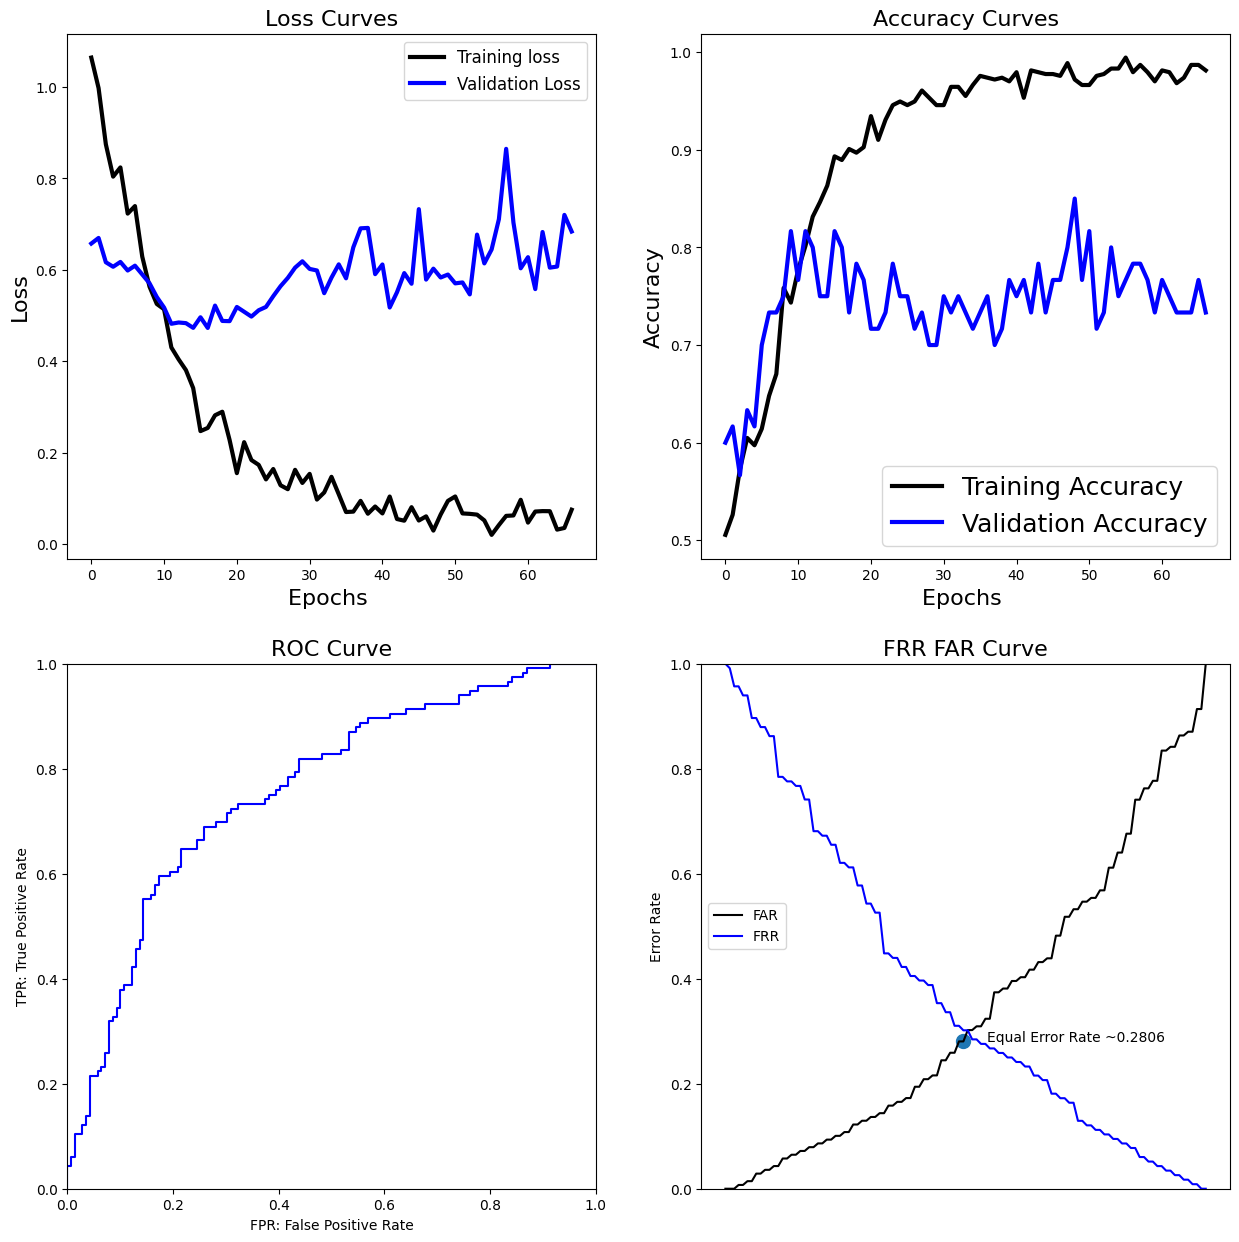

In [15]:
network_analysis(mlp_model,mlp_fit,X_test,y_test)

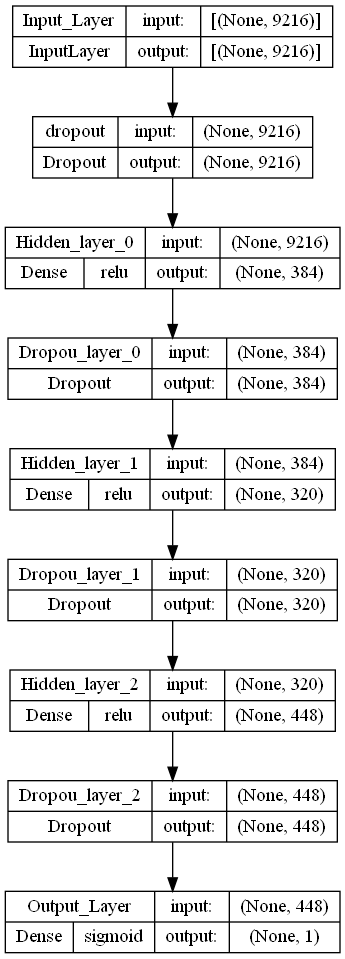

In [16]:
plot_model(mlp_model,dpi=96,show_shapes=True,show_layer_activations=True)

In [17]:
stratified_kfold = StratifiedKFold(n_splits=5,
                                       random_state=42,
                                       shuffle=True)

test_accuracy = []

for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mlp_model=build_mlp_model(mlp_hyperparameters)
    mlp_fit=network_fit(mlp_model,X_train,y_train)    
    test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
    test_accuracy.append(test_acc)

Epoch 1/200
39/39 - 1s - loss: 1.0239 - accuracy: 0.4910 - val_loss: 0.6877 - val_accuracy: 0.5294 - 1s/epoch - 27ms/step
Epoch 2/200
39/39 - 0s - loss: 0.9028 - accuracy: 0.5466 - val_loss: 0.6736 - val_accuracy: 0.6912 - 471ms/epoch - 12ms/step
Epoch 3/200
39/39 - 0s - loss: 0.9001 - accuracy: 0.5417 - val_loss: 0.6624 - val_accuracy: 0.6618 - 347ms/epoch - 9ms/step
Epoch 4/200
39/39 - 0s - loss: 0.8186 - accuracy: 0.5466 - val_loss: 0.6621 - val_accuracy: 0.6176 - 258ms/epoch - 7ms/step
Epoch 5/200
39/39 - 0s - loss: 0.7579 - accuracy: 0.5712 - val_loss: 0.6194 - val_accuracy: 0.6912 - 255ms/epoch - 7ms/step
Epoch 6/200
39/39 - 0s - loss: 0.7138 - accuracy: 0.6039 - val_loss: 0.6460 - val_accuracy: 0.7059 - 252ms/epoch - 6ms/step
Epoch 7/200
39/39 - 0s - loss: 0.6875 - accuracy: 0.6268 - val_loss: 0.5881 - val_accuracy: 0.6471 - 253ms/epoch - 6ms/step
Epoch 8/200
39/39 - 0s - loss: 0.6829 - accuracy: 0.6628 - val_loss: 0.5875 - val_accuracy: 0.6618 - 258ms/epoch - 7ms/step
Epoch 9/2

Epoch 4/200
39/39 - 0s - loss: 0.8051 - accuracy: 0.5630 - val_loss: 0.6264 - val_accuracy: 0.6324 - 298ms/epoch - 8ms/step
Epoch 5/200
39/39 - 0s - loss: 0.7877 - accuracy: 0.5908 - val_loss: 0.6278 - val_accuracy: 0.7059 - 301ms/epoch - 8ms/step
Epoch 6/200
39/39 - 0s - loss: 0.7464 - accuracy: 0.6105 - val_loss: 0.6123 - val_accuracy: 0.6765 - 303ms/epoch - 8ms/step
Epoch 7/200
39/39 - 0s - loss: 0.7046 - accuracy: 0.6432 - val_loss: 0.6015 - val_accuracy: 0.6471 - 293ms/epoch - 8ms/step
Epoch 8/200
39/39 - 0s - loss: 0.6340 - accuracy: 0.6776 - val_loss: 0.6186 - val_accuracy: 0.6765 - 292ms/epoch - 7ms/step
Epoch 9/200
39/39 - 0s - loss: 0.5830 - accuracy: 0.7463 - val_loss: 0.6289 - val_accuracy: 0.6176 - 288ms/epoch - 7ms/step
Epoch 10/200
39/39 - 0s - loss: 0.5212 - accuracy: 0.7496 - val_loss: 0.6180 - val_accuracy: 0.6912 - 296ms/epoch - 8ms/step
Epoch 11/200
39/39 - 0s - loss: 0.4569 - accuracy: 0.7987 - val_loss: 0.6094 - val_accuracy: 0.7059 - 293ms/epoch - 8ms/step
Epoch 

Epoch 12/200
39/39 - 0s - loss: 0.4081 - accuracy: 0.8216 - val_loss: 0.5683 - val_accuracy: 0.7059 - 317ms/epoch - 8ms/step
Epoch 13/200
39/39 - 0s - loss: 0.3953 - accuracy: 0.8216 - val_loss: 0.5769 - val_accuracy: 0.6912 - 300ms/epoch - 8ms/step
Epoch 14/200
39/39 - 0s - loss: 0.3515 - accuracy: 0.8412 - val_loss: 0.5950 - val_accuracy: 0.7206 - 305ms/epoch - 8ms/step
Epoch 15/200
39/39 - 0s - loss: 0.3097 - accuracy: 0.8658 - val_loss: 0.5954 - val_accuracy: 0.7059 - 304ms/epoch - 8ms/step
Epoch 16/200
39/39 - 0s - loss: 0.2892 - accuracy: 0.8854 - val_loss: 0.5751 - val_accuracy: 0.7353 - 306ms/epoch - 8ms/step
Epoch 17/200
39/39 - 0s - loss: 0.2552 - accuracy: 0.9116 - val_loss: 0.5507 - val_accuracy: 0.7500 - 323ms/epoch - 8ms/step
Epoch 18/200
39/39 - 0s - loss: 0.2646 - accuracy: 0.8985 - val_loss: 0.6046 - val_accuracy: 0.7353 - 302ms/epoch - 8ms/step
Epoch 19/200
39/39 - 0s - loss: 0.1953 - accuracy: 0.9214 - val_loss: 0.6163 - val_accuracy: 0.7500 - 292ms/epoch - 7ms/step


Epoch 16/200
39/39 - 0s - loss: 0.2976 - accuracy: 0.8723 - val_loss: 0.6393 - val_accuracy: 0.7353 - 307ms/epoch - 8ms/step
Epoch 17/200
39/39 - 0s - loss: 0.3026 - accuracy: 0.8822 - val_loss: 0.6384 - val_accuracy: 0.6618 - 303ms/epoch - 8ms/step
Epoch 18/200
39/39 - 0s - loss: 0.2531 - accuracy: 0.8936 - val_loss: 0.6651 - val_accuracy: 0.6765 - 299ms/epoch - 8ms/step
Epoch 19/200
39/39 - 0s - loss: 0.2616 - accuracy: 0.8985 - val_loss: 0.6900 - val_accuracy: 0.6618 - 299ms/epoch - 8ms/step
Epoch 20/200
39/39 - 0s - loss: 0.2183 - accuracy: 0.9214 - val_loss: 0.7364 - val_accuracy: 0.6618 - 296ms/epoch - 8ms/step
Epoch 21/200
39/39 - 0s - loss: 0.2415 - accuracy: 0.9149 - val_loss: 0.8532 - val_accuracy: 0.6324 - 295ms/epoch - 8ms/step
Epoch 22/200
39/39 - 0s - loss: 0.1875 - accuracy: 0.9133 - val_loss: 0.7526 - val_accuracy: 0.6471 - 305ms/epoch - 8ms/step
Epoch 23/200
39/39 - 0s - loss: 0.2461 - accuracy: 0.9116 - val_loss: 0.7579 - val_accuracy: 0.6618 - 302ms/epoch - 8ms/step


Epoch 21/200
39/39 - 0s - loss: 0.2040 - accuracy: 0.9183 - val_loss: 0.5557 - val_accuracy: 0.7794 - 288ms/epoch - 7ms/step
Epoch 22/200
39/39 - 0s - loss: 0.1686 - accuracy: 0.9314 - val_loss: 0.7001 - val_accuracy: 0.7500 - 290ms/epoch - 7ms/step
Epoch 23/200
39/39 - 0s - loss: 0.1635 - accuracy: 0.9363 - val_loss: 0.6235 - val_accuracy: 0.7941 - 289ms/epoch - 7ms/step
Epoch 24/200
39/39 - 0s - loss: 0.1310 - accuracy: 0.9542 - val_loss: 0.6132 - val_accuracy: 0.8235 - 294ms/epoch - 8ms/step
Epoch 25/200
39/39 - 0s - loss: 0.1531 - accuracy: 0.9363 - val_loss: 0.6656 - val_accuracy: 0.7353 - 285ms/epoch - 7ms/step
Epoch 26/200
39/39 - 0s - loss: 0.1529 - accuracy: 0.9493 - val_loss: 0.7179 - val_accuracy: 0.7647 - 290ms/epoch - 7ms/step
Epoch 27/200
39/39 - 0s - loss: 0.1545 - accuracy: 0.9542 - val_loss: 0.7012 - val_accuracy: 0.7647 - 299ms/epoch - 8ms/step
Epoch 28/200
39/39 - 0s - loss: 0.1079 - accuracy: 0.9477 - val_loss: 0.6892 - val_accuracy: 0.7206 - 296ms/epoch - 8ms/step


In [18]:
print('List of possible accuracy:', test_accuracy)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(test_accuracy)*100, '%')
print('\nMinimum Accuracy:',
      min(test_accuracy)*100, '%')
print('\nOverall Accuracy:',
      mean(test_accuracy)*100, '%')
print('\nStandard Deviation is:', stdev(test_accuracy))

List of possible accuracy: [0.729411780834198, 0.7823529243469238, 0.6529411673545837, 0.6823529601097107, 0.6449704170227051]

Maximum Accuracy That can be obtained from this model is: 78.23529243469238 %

Minimum Accuracy: 64.49704170227051 %

Overall Accuracy: 69.84058499336243 %

Standard Deviation is: 0.05742072182072464
